# 13. Revisiting the multi-spore experiments

## Numerical experiments - Week 17/2025

_Boyan Mihaylov, MSc Computational Science (UVA/VU)_

Having obtained more concrete estimates of the concentrations and diffusion coefficients of potential inhibitors, the quantitative effect of crowding on germination can be revisited in more detail. The computed reimaining inhibitor concentration in the spore under varying densities of regularly distributed spores can be related to statistical data from empirical experiments.

## Prerequisite libraries

In [6]:
using CurveFit
using PyPlot
using Printf
using Revise

Revise.includet("./conversions.jl")
Revise.includet("./diffusion.jl")
Revise.includet("./setup.jl")
Revise.includet("./plotting.jl")
Revise.includet("./analysis.jl")
using .Conversions
using .Diffusion
using .Setup
using .Plotting
using .Analysis

## 1. General assumptions

Previously, it was shown that the concentration threshold for germination inhibition in a single spore could lie anywhere between $10^{-10}$ and $10^{-6}\ \textrm{M}$. Matching these thresholds to effective permeation constants, diffusion simulations under increasing spore densities from $10^4$ to $10^9$ spores/mL are performed, recording the numerically estimated relaxation exponent and the inhibitor concentrations in the spores over the course of $t=12$ hours.

## 2. 3D spore grid

The most simple setup assumes a regular three-dimensional grid of spores or, equivalently, a triply periodic lattice. The different spore arrangements are visualised below.

Spore density: 1.0e-8 spores per micrometer^3
Populating volume of 1000000000 micrometers^3 with 1.0e-8 spores per um^3, 0.002154434690031884 spores per dimension
Spore spacing: 464.15888336127784 micrometers
Spore density: 1.7782794100389225e-8 spores per micrometer^3
Populating volume of 1000000000 micrometers^3 with 1.7782794100389225e-8 spores per um^3, 0.0026101572156825366 spores per dimension
Spore spacing: 383.1186849557288 micrometers
Spore density: 3.162277660168379e-8 spores per micrometer^3
Populating volume of 1000000000 micrometers^3 with 3.162277660168379e-8 spores per um^3, 0.0031622776601683794 spores per dimension
Spore spacing: 316.2277660168379 micrometers
Spore density: 5.6234132519034905e-8 spores per micrometer^3
Populating volume of 1000000000 micrometers^3 with 5.6234132519034905e-8 spores per um^3, 0.0038311868495572877 spores per dimension
Spore spacing: 261.0157215682537 micrometers
Spore density: 1.0e-7 spores per micrometer^3
Populating volume of 100000000

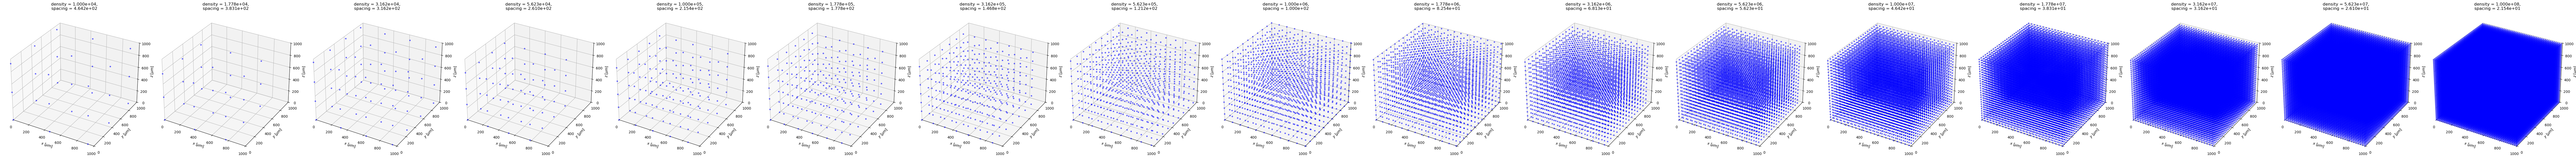

In [7]:
spore_densities = 10 .^ (4:0.25:8)

spore_arrangements = []
labels = []
spore_spacings = []
for spore_density in spore_densities
    spore_coords, spore_spacing = generate_spore_positions(spore_density, 1000, 1000, base_height=nothing)
    push!(spore_arrangements, spore_coords)
    push!(labels, "density = $(@sprintf("%.3e", round(Int, spore_density))),\nspacing = $(@sprintf("%.3e", round(spore_spacing, digits=2)))")
    push!(spore_spacings, spore_spacing)
end

plot_spore_arrangements(1000, 1000, spore_arrangements, labels)

In [19]:
plot_spore_arrangements(1000, 1000, spore_arrangements[1:4:end], labels[1:4:end], figsize=2.5)

In [20]:
# Global parameters
D = cm2_to_um2(6.902e-6) # [um^2/s]
t_max = 14400 # s
c₀ = 1.53 # x10^(-5) M
spore_diameter = 5 # microns
spore_rad = spore_diameter / 2 # microns
A, V = compute_spore_area_and_volume_from_dia(spore_diameter)
K = 1#316.23 # partition coefficient, set to 1 since we don't necessarily deal with lipid membranes

n_save_frames = 100
fit_lim = (0.0, 600.0) # s

# Variable parameters
cT_range = 10.0 .^ (-10:-6) # M
Ps_range = compute_permeation_constant.(cT_range, 0.0, c₀, t_max, A, V)

# Analytical solutions (round spore)
times_analytical = collect(LinRange(0, t_max, n_save_frames))
times_mask = (times_analytical .>= fit_lim[1]) .& (times_analytical .<= fit_lim[2])
c_finals_an = zeros(length(spore_densities), length(Ps_range))
exponents_an = zeros(length(spore_densities), length(Ps_range))
for (i, ρₛ) in enumerate(spore_densities)

    ϕ = inverse_mL_to_cubic_um(ρₛ) * V # volume fraction

    for (j, Pₛ) in enumerate(Ps_range)
        c_analytical = concentration_at_spore_ambient_sources(times_analytical, c₀, 0.0, ρₛ, spore_rad, Pₛ)
        c_finals_an[i, j] = c_analytical[end]

        # Fit and normalise exponent
        fit = exp_fit(times_analytical[times_mask], c_analytical[times_mask])
        τ = V / (A * Pₛ)
        exponents_an[i, j] = - fit[2] * τ * (1 - ϕ)
    end
end

# Analytical solutions (cubic spore)
# A_cubic = 150
# V_cubic = 125
# c_finals_an_cubic = zeros(length(spore_densities), length(Ps_range))
# exponents_an_cubic = zeros(length(spore_densities), length(Ps_range))
# for (i, ρₛ) in enumerate(spore_densities)
    
#     ρₛ = inverse_mL_to_cubic_um(ρₛ) # spores/mL to spores/um^3
#     ϕ = ρₛ * V_cubic # volume fraction

#     for (j, Pₛ) in enumerate(Ps_range)
#         τ = V_cubic / (A_cubic * Pₛ)

#         c_analytical = ϕ * c₀ .+ (1 - ϕ) .* c₀ .* exp.(-times_analytical ./ (τ .* (1 - ϕ)))
#         c_finals_an_cubic[i, j] = c_analytical[end]

#         # Fit and normalise exponent
#         fit = exp_fit(times_analytical[times_mask], c_analytical[times_mask])
#         exponents_an_cubic[i, j] = - fit[2] * τ * (1 - ϕ)
#     end
# end

# Simulation parameters
sim_params = Dict(
    :sim_res => "medium",
    :N => round.(Int, spore_spacings ./ 5.0),
    :dx => 5.0,
    :dt => 0.005,
    :t_max => t_max,
    :D => D,
    :Ps => Ps_range,
    :c0 => c₀,
    :n_save_frames => n_save_frames,
    :fit_max => fit_lim[2]
)

run_simulations("250603_multi_spore", sim_params)

N = 93
Ps = 0.0013571249227630091
Using D = 690.2, Db = 0.006785624613815046, Ps = 0.0013571249227630091
Storage arrays allocated.
N = 77
Ps = 0.0013571249227630091
New simulation with parameters Dict{Symbol, Any}(:N => 77, :fit_max => 600.0, :Ps => 0.0013571249227630091, :n_save_frames => 100, :D => 690.2, :t_max => 14400, :sim_res => "medium", :dx => 5.0, :dt => 0.005, :c0 => 1.53) added with simID N_2_Ps_1.
Using D = 690.2, Db = 0.006785624613815046, Ps = 0.0013571249227630091
Storage arrays allocated.
N = 63
Ps = 0.0013571249227630091
New simulation with parameters Dict{Symbol, Any}(:N => 63, :fit_max => 600.0, :Ps => 0.0013571249227630091, :n_save_frames => 100, :D => 690.2, :t_max => 14400, :sim_res => "medium", :dx => 5.0, :dt => 0.005, :c0 => 1.53) added with simID N_3_Ps_1.
Using D = 690.2, Db = 0.006785624613815046, Ps = 0.0013571249227630091
Storage arrays allocated.
N = 52
Ps = 0.0013571249227630091
New simulation with parameters Dict{Symbol, Any}(:N => 52, :fit_max => 600.

The functional relationship between spore denisty and residual concentration is plotted below.

Analytical modeldiameter not found.
Fitted exponential: (1.0000014033390547, -1.088717777354611e-10)
Numerical model
Fitted exponential: (0.9999819524818812, -1.4728036765358846e-10)
Analytical model
Numerical model
Analytical model
Fitted exponential: (1.0000013494859634, -1.0331865026252388e-10)
Numerical model
Fitted exponential: (1.0000032712035842, -1.364594758349049e-10)
Analytical model
Numerical model
Analytical model
Fitted exponential: (1.0000012868536845, -9.810432443972814e-11)
Numerical model
Fitted exponential: (0.9999632427416334, -1.2642426256075807e-10)
Analytical model
Numerical model
Analytical model
Fitted exponential: (1.0000012182780245, -9.320656995177073e-11)
Numerical model
Fitted exponential: (0.9999352521755029, -1.1729736641653278e-10)
Analytical model
Numerical model
Analytical model
Fitted exponential: (1.0000011460357523, -8.860464403982662e-11)
Numerical model
Fitted exponential: (1.000051133334249, -1.100927786784616e-10)
Analytical model
Numerical mode

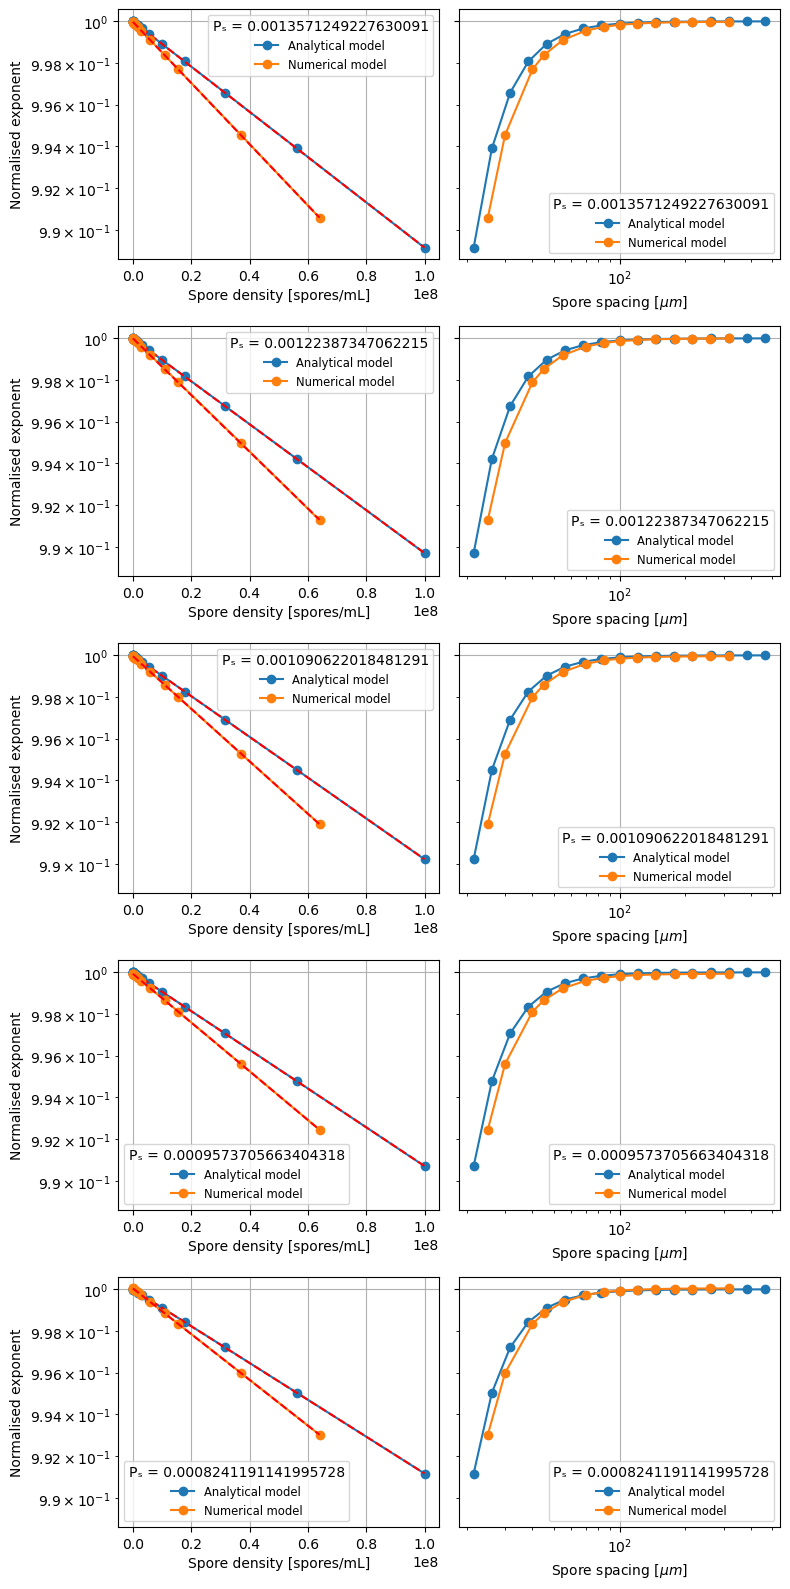

In [38]:
matplotlib.pyplot.close()

# Read simulation results
sim_results = get_density_and_exponent_from_files("250603_multi_spore", norm_exponent=true)
Ps_unique = unique(sim_results[:Ps])
densities_unique = unique(sim_results[:spore_density])
spacings_unique = unique(sim_results[:spore_spacing])

fig, axs = subplots(length(Ps_unique), 2, figsize=(8, 16), sharex=false, sharey=true)

for (i, Pₛ) in enumerate(Ps_unique)
    filter_mask = sim_results[:Ps] .== Pₛ
    densities_numerical = zeros(sum(filter_mask))
    spacings_numerical = zeros(sum(filter_mask))
    exponents_numerical = zeros(sum(filter_mask))
    for (j, ρₛ) in enumerate(densities_unique)
        densities_numerical[j] = ρₛ
        spacings_numerical[j] = spacings_unique[j]
        exponents_numerical[j] = sim_results[:exponent][filter_mask][j]
    end

    sort_indices = sortperm(densities_numerical)
    densities_numerical = densities_numerical[sort_indices]
    spacings_numerical = spacings_numerical[sort_indices]
    exponents_numerical = exponents_numerical[sort_indices]

    compare_functional_relationships([spore_densities, densities_numerical[3:end-1]],
                                    [exponents_an[:, i], exponents_numerical[3:end-1]],
                                    ["Spore density [spores/mL]", "Normalised exponent"],
                                    ["Analytical model", "Numerical model"], ax=axs[i, 1], logy=true, fit="exp")
    axs[i, 1].legend(title="Pₛ = $Pₛ", fontsize="small")

    compare_functional_relationships([spore_spacings, spacings_numerical[3:end-1]],
                                    [exponents_an[:, i], exponents_numerical[3:end-1]],
                                    [L"\text{Spore spacing}\ [\mu m]", "Normalised exponent"],
                                    ["Analytical model", "Numerical model"], ax=axs[i, 2], logx=true)
    axs[i, 2].legend(title="Pₛ = $Pₛ", fontsize="small")
    axs[i, 2].set_ylabel(nothing)
    # axs[i, 2].set_ylim(0.9, 1.01)
end

tight_layout()
gcf()

Sample density: 2.962962962962963e8 spores/mL
Equilibrium concentration: 0.029088820866572156
0.026600135143382286
Fitted exponential: (1.496244293076353, -0.0009711450713904106)
Fitted exponential: (1.4980637763786857, -0.000979084970718376)


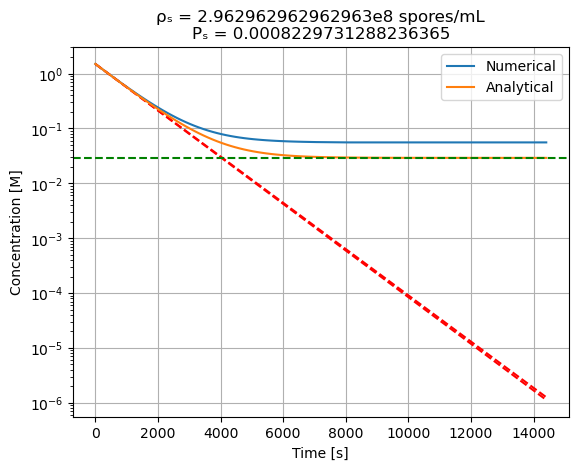

In [9]:
matplotlib.pyplot.close()

times, concentrations, param_dict = get_concentration_evolution_from_file("250506_multi_spore", "N_17_Ps_5"; get_frames=false)

sample_density = 1 / (param_dict[:N][1] * spore_diameter) ^ 3 # spores/um^3
sample_density = inverse_cubic_um_to_mL(sample_density) # spores/mL
sample_Ps = param_dict[:Ps][1]
concentrations_an = concentration_at_spore_ambient_sources(times, c₀, 0.0, sample_density, spore_rad, sample_Ps)
c_eq = compute_c_eq(sample_density, V, c₀, 0.0)

println("Sample density: ", sample_density, " spores/mL")
println("Equilibrium concentration: ", c_eq)

println(maximum(concentrations .- concentrations_an))

fig, ax = subplots()
compare_concentration_evolutions([concentrations, concentrations_an], [times, times], ["Numerical", "Analytical"], ax, fit_lim=(0, 600), title="ρₛ = $sample_density spores/mL\nPₛ = $sample_Ps")
# ax.set_xscale("log")
ax.axhline(y=c_eq, color="green", linestyle="--", label="Equilibrium concentration")
ax.set_yscale("log")

gcf()

The results show that, in the pre-saturation time period, the numerical model approximates the analytical solution closely, despite being based on an orthogonal lattice. It also appears that the magnitude of the exponent in the density-concentration relationship slightly decreases with the permeation constant, from about $-1.01\times10^{-10}$ for $P_s=0.00136$ to $-7.78\times10^{-11}$ for $P_s=0.0008$.

## 3. 2D spore grid in a 3D volume

# References